In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# notebook for linear regression

problem is to proove **moore's law**, which states the number of transistors per square inch on integrated circuits doubles approximately every 2 years

the law is akin to exponential growth: 
$$
C = A_0 r^t
$$
where C is the transistor count, r is the growth rate and t is time.

how to do this with **linear** regression, if the equation is exponential? answer: take the log of both sides
$$
log(C) = t log(r) + log(A_0)
$$

In [3]:
# get the data (this is from his "data links")
!wget https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/moore.csv

--2023-03-31 21:27:19--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/moore.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2302 (2.2K) [text/plain]
Saving to: ‘moore.csv’

moore.csv           100%[===================>]   2.25K  --.-KB/s    in 0s      

2023-03-31 21:27:19 (28.9 MB/s) - ‘moore.csv’ saved [2302/2302]



In [4]:
# check to see if it has a header
!head moore.csv

1971,2300
1972,3500
1973,2500
1973,2500
1974,4100
1974,4500
1974,8000
1975,3510
1976,5000
1976,8500


In [5]:
# load in the data - use pandas bc its a csv
# convert it to a np array (add .to_numpy(), this changes frequently so double check)
data = pd.read_csv('moore.csv', header=None).to_numpy()

In [6]:
# split up x's and y's, or inputs and targets
# first column in year (time) so input, second column is count so output

# first reshape
# why (-1,1)? -1 is a wildcard, put there whatever is left (N)
# why reshape? most ML libraries assume X to be 2D or (N,D), so reshape to 2D (N,1) as D=1 
X = data[:,0].reshape(-1,1)
Y = data[:,1]

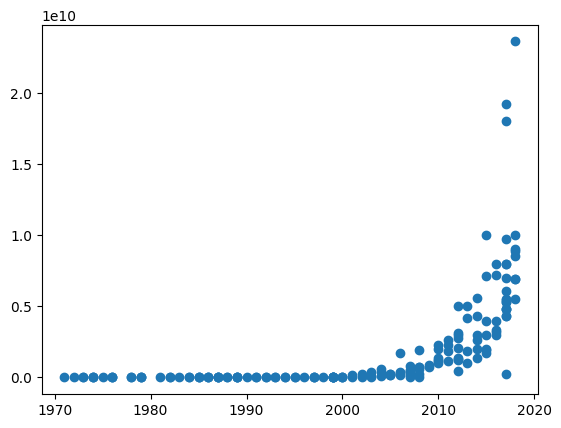

In [7]:
# plot the data - in current form expect exponential growth
plt.scatter(X, Y)
plt.show()

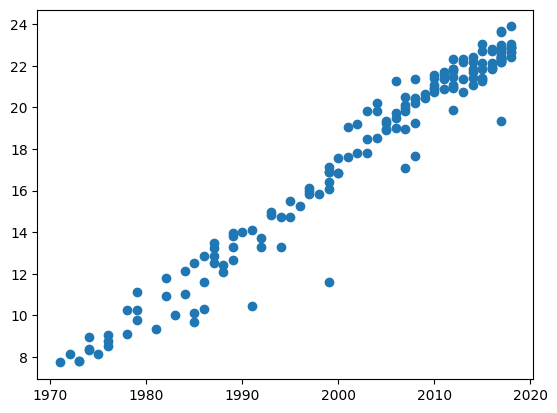

In [8]:
# now need to linearize - take the log of Y
Y = np.log(Y)
plt.scatter(X, Y)
plt.show()

In [9]:
# we want to translate the data 
# can do this by shifting by the mean or dividing by the std
X = X - X.mean()

# note: shifting by the mean has advantages for later on, but screws up the compiling
# which is why we have to use SGD. if you scale by dividing by std, you could just use
# the adam optimizer

In [10]:
# make the model (see written notes)
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1,)), # input dimension (D) is 1
    tf.keras.layers.Dense(1)           # output shape also 1
])

In [11]:
# onto compiling - optimizer has to be custom bc of scaling 
model.compile(
    optimizer = tf.keras.optimizers.SGD(0.001, 0.9),  # input is (learning rate, momentum)
    loss = 'mse'
)

In [12]:
# learning rate scheduling (see written notes)
# this is useful when traditional optimizers like adam don't work
def schedule(epoch, lr):  # epoch number, learning rate
  if epoch >= 50: 
    return 0.0001
  return 0.001

# so function will change the learning rate if epoch number passes 50

# to use this, create a learning rate scheduler object using tf
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

In [13]:
# now train the model
# choice of epoch depends on the problem - trial and error 
r = model.fit(X, Y, epochs=200, callbacks=[scheduler])

Epoch 1/200
6/6 [==============================] - 2s 10ms/step - loss: 453.4203 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 0s 12ms/step - loss: 329.1582 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 0s 12ms/step - loss: 292.0097 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 0s 23ms/step - loss: 201.6705 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 164.8403 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 0s 7ms/step - loss: 123.3873 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 0s 7ms/step - loss: 99.8036 - lr: 0.0010
Epoch 8/200
6/6 [==============================] - 0s 5ms/step - loss: 75.4755 - lr: 0.0010
Epoch 9/200
6/6 [==============================] - 0s 16ms/step - loss: 71.4194 - lr: 0.0010
Epoch 10/200
6/6 [==============================] - 0s 5ms/step - loss: 67.0960 - lr: 0.0010
Epoch 11/200
6/6 [==============================] - 0s 28ms/step - l

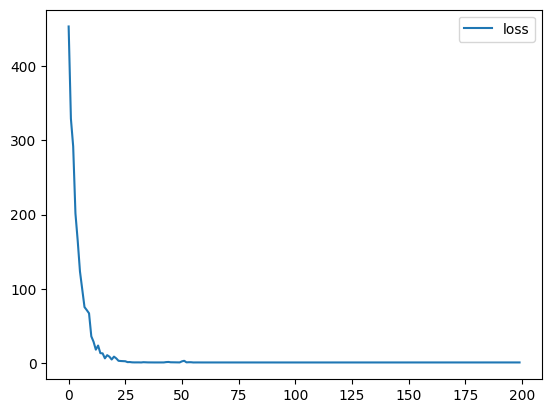

In [14]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.legend()
plt.show()

# from this plot, you can see we could have done a lot less epochs! 
# so you can go back and adjust the model, especially if it takes a while to run

In [15]:
# the goal with this is less about prediction, more about modeling the data
# which is why there's no train / test split, no prediction

# instead, let's see what kind of data we can get out of the model
# like layers
model.layers

In [16]:
# it doesn't show input layer, just the dense layer(s)
# from here, you can get the weights of a dense layer (specifiy which with []):
model.layers[0].get_weights()

# this will return a list of arrays, or 1x1 matricies 

[array([[0.33157432]], dtype=float32), array([17.753082], dtype=float32)]

In [17]:
# can interpret the weights, first of which is the slope
# [0] is zeroth entry, [0,0] is the first "matrix" value
a = model.layers[0].get_weights()[0][0,0]
print('a = ', a)

# note: there is a component of randomness to the learning process, so a 
# will take a different value each time you run this

a =  0.33157432


Now, we can go more into the theory to actually predict Moore's law. 

the linear regression model is: 
$$
\hat{y} = ax + b
$$
where $\hat{y} = \text{log}~C$, $a = \text{log}~r$, $x = t$, and $b = \text{log}~A_0$. 

we want $r$ or the growth rate. our slope or $a$ is:
$$
a = 0.35820135
$$
(shown above), so we can calculate $r$ as: 
$$
r = e^{a} = e^{0.35820135} = 1.430753674
$$

to find the time it takes for transistor count to double, we need to find the amount of time it takes for $C$ to become $2C$. 

the original (intial starting time, $t_0$): 
$$
C = A_0 r^{t_0} ~~~~~~~~ [1]
$$
and next time step, $t_1$: 
$$
2C = A_0 r^{t_1} ~~~~~~~~ [2]
$$

combine eqns as [2] / [1]: 
$$
2C/C = A_0 r^{t_1} / A_0 r^{t_0} → 2 = r^{t_1 - t_0}
$$

solve for the difference in time:
$$
t_1 - t_0 = \Delta t = \frac{\text{log}~2}{\text{log}~r} = \frac{\text{log}~2}{a}
$$
and we want $\Delta t$, as we're trying to proove the rate of count doubling should be roughly 2 years. 

In [18]:
# solve for the time difference
del_t = np.log(2) / a
print('time to double: ', del_t)

# note: here's where not scaling by std is nice. if we did scale the data by dividing
# by std, we would have to scale this answer back to actually get the right value

time to double:  2.090473046591433


## part 2: making predictions

6/6 [==============================] - 0s 2ms/step


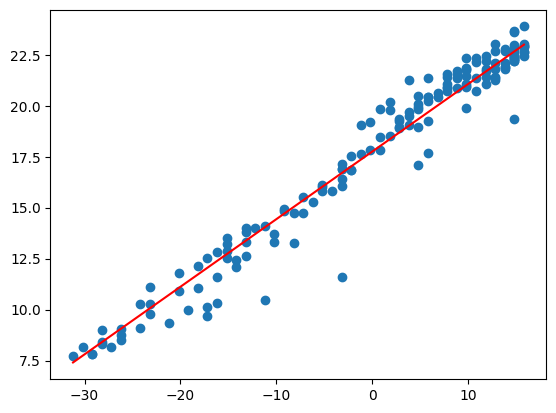

In [19]:
# now we'll look at the line and see if it fits our data
# note: need to flatten predictions since targets are size (N,) and predictions are (N,1)
Yhat = model.predict(X).flatten()
plt.scatter(X, Y)
plt.plot(X, Yhat, color='red')
plt.show()

In [20]:
# now to ensure the dense layer of the network actually does y_hat = wx+b as discussed in lectures
# first, get the weights
w, b = model.layers[0].get_weights()

# reshape x back to a 2D array (as it was flattened in the last cell)
X = X.reshape(-1,1)

# calculate the predictions manually using the weights
# flatten again or else it will be (N,1)
Yhat2 = (X.dot(w) + b).flatten()

# now check Yhat is equal to Yhat2 
# can't use == for floating points, instead check the difference with "allclose" function
# which will return true (points match) or false (points don't match)
np.allclose(Yhat, Yhat2)

True